In [1]:
import numpy as np
import pandas as pd
df_1 = pd.read_csv("中西_dataset.csv")
df_1.head()
df_2 = pd.read_csv("安平_dataset.csv")
df_2.head()
df = pd.concat([df_1, df_2])

/var/folders/wt/6hl8qhss3jz9zrdh6n8f3_qh0000gn/T/ipykernel_1062/1955930566.py:3: DtypeWarning: Columns (47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1 = pd.read_csv("中西_dataset.csv")
/var/folders/wt/6hl8qhss3jz9zrdh6n8f3_qh0000gn/T/ipykernel_1062/1955930566.py:5: DtypeWarning: Columns (0,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2 = pd.read_csv("安平_dataset.csv")


In [ ]:
df["ParkingSegmentID"] = df["ParkingSegmentID"].astype(str)
df.loc[
    (df["ParkingSegmentID"] == "1192") &
    (df["half_hour_interval"] == 20) &
    (df["month_val"] == 3) &
    (df["day_val"] == 8),
    "TotalSpaces"
] = 63
indices_to_drop = df[(df['ParkingSegmentID'] == "1131") & (df['year_val'] == 2025) & (df['month_val'] == 3) & (df['day_val'] == 27)].index
df.drop(indices_to_drop, inplace=True)
indices_to_drop = df[(df["year_val"] == 2025) & (df["month_val"] == 2) & (df["day_val"] == 20) & (df["half_hour_interval"] == 29) & (df["ParkingSegmentID"] == "54555420") & (df["TotalSpaces"] == 1036)].index
df.drop(indices_to_drop, inplace=True)
condition = df["avg_available_spots"] > df["TotalSpaces"]
# extract the values from df["TotalSpaces"] on the right side that meet the condition.
values_to_assign = df.loc[condition, "TotalSpaces"].values
df.loc[condition, "avg_available_spots"] = values_to_assign

In [ ]:
df["weekday"] = df["weekday_x"]

df['district'] = df['district'].map({'中西區': 0, '安平區': 1})
df['year_val'] = df["year_val"].map({2024:False, 2025:True})
# merge one-hot features.

weekday_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
                       'Friday': 4, 'Saturday': 5, 'Sunday': 6}
df['weekday_num'] = df['weekday'].map(weekday_mapping)

df['wind_direction_10m_sin'] = np.sin(np.deg2rad(df['wind_direction_10m']))
df['wind_direction_10m_cos'] = np.cos(np.deg2rad(df['wind_direction_10m']))
df['wind_direction_120m_sin'] = np.sin(np.deg2rad(df['wind_direction_120m']))
df['wind_direction_120m_cos'] = np.cos(np.deg2rad(df['wind_direction_120m']))
df['wind_direction_80m_sin'] = np.sin(np.deg2rad(df['wind_direction_80m']))
df['wind_direction_80m_cos'] = np.cos(np.deg2rad(df['wind_direction_80m']))
df.drop(columns=["wind_direction_10m","wind_direction_120m","wind_direction_80m"],inplace=True)


In [ ]:

df_final = df.drop(columns=[          
    'weekday',        
    'weekday_y',"date","latitude","longitude","datetime_hour","time", "weekday_x","holiday_name",
])
def add_cyclical_features(df):
    # month (1–12 → 12 periods)
    
    # date (1–31 → 31 periods)
    df['day_sin'] = np.sin(2 * np.pi * df['day_val'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day_val'] / 31)
    
    # half-hour intervals (0–47 → 48 periods)
    df['half_hour_sin'] = np.sin(2 * np.pi * df['half_hour_interval'] / 48)
    df['half_hour_cos'] = np.cos(2 * np.pi * df['half_hour_interval'] / 48)
    
    return df

df_final = add_cyclical_features(df_final)
df_final = pd.get_dummies(df_final, columns=['month_val', 'weekday_num'])

In [5]:
df_final.drop(columns=["ParkingSegmentID"],inplace=True)

In [6]:
df_final["day_off"] = df_final["is_national_holiday"] | df_final["weekday_num_6"] | df_final["weekday_num_5"]
df_final.drop(columns=["is_national_holiday"],inplace=True)

In [7]:
df_final["datetime"] = pd.to_datetime(df_final["datetime"])
df_train = df_final[df_final["datetime"] < "2025-01-23"]
df_val = df_final[(df_final["datetime"] >= "2025-01-23") & (df_final["datetime"] < "2025-03-23")]
df_test = df_final[df_final["datetime"] >= "2025-03-23"]
df_train.drop(columns=["datetime"], inplace=True)
df_val.drop(columns=["datetime"], inplace=True)
df_test.drop(columns=["datetime"], inplace=True)

/var/folders/wt/6hl8qhss3jz9zrdh6n8f3_qh0000gn/T/ipykernel_1062/3821183271.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=["datetime"], inplace=True)
/var/folders/wt/6hl8qhss3jz9zrdh6n8f3_qh0000gn/T/ipykernel_1062/3821183271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.drop(columns=["datetime"], inplace=True)
/var/folders/wt/6hl8qhss3jz9zrdh6n8f3_qh0000gn/T/ipykernel_1062/3821183271.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [8]:
X_train = df_train.drop(columns=["avg_available_spots"])
y_train = df_train['avg_available_spots']
X_val = df_val.drop(columns=["avg_available_spots"])
y_val = df_val['avg_available_spots']

In [9]:
X_train.drop(columns=["day_val","half_hour_interval","hour"],inplace=True)
X_val.drop(columns=["day_val","half_hour_interval","hour"],inplace=True)

In [10]:
num_cols = X_train.select_dtypes(include=[np.number]).columns
num_cols = num_cols.difference(['day_sin', 'day_cos', 'half_hour_sin', 'half_hour_cos','wind_direction_10m_sin', 'wind_direction_10m_cos', 'wind_direction_120m_sin', 'wind_direction_120m_cos', 'wind_direction_80m_sin', 'wind_direction_80m_cos','year_val'])
bool_cols = X_train.select_dtypes(include=['bool']).columns

In [11]:
X_train.columns

Index(['year_val', 'district', 'TotalSpaces', 'lat', 'lon', 'firstHourFee',
       'laterHourFee', 'precipitation', 'apparent_temperature',
       'relative_humidity_2m', 'temperature_2m', 'cloud_cover',
       'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high', 'visibility',
       'wind_speed_10m', 'temperature_80m', 'temperature_120m', 'showers',
       'pressure_msl', 'surface_pressure', 'wind_speed_80m', 'wind_speed_120m',
       'wind_gusts_10m', 'evapotranspiration', 'et0_fao_evapotranspiration',
       'vapour_pressure_deficit', 'dew_point_2m',
       'terrestrial_radiation_instant', 'wind_direction_10m_sin',
       'wind_direction_10m_cos', 'wind_direction_120m_sin',
       'wind_direction_120m_cos', 'wind_direction_80m_sin',
       'wind_direction_80m_cos', 'day_sin', 'day_cos', 'half_hour_sin',
       'half_hour_cos', 'month_val_1', 'month_val_2', 'month_val_3',
       'month_val_4', 'month_val_5', 'month_val_6', 'month_val_7',
       'month_val_8', 'month_val_9', 'mon

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import PredefinedSplit
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])


# merge the training and validation sets
X_all = np.vstack([X_train, X_val])
y_all = np.concatenate([y_train, y_val])

# define a fixed split: -1 indicates training, 0 indicates validation
test_fold = np.array([-1] * len(X_train) + [0] * len(X_val))
ps = PredefinedSplit(test_fold)

# ElasticNetCV is only used for hyperparameter tuning and feature selection (no additional prediction needed)
enet = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.9],
    n_alphas=50,
    cv=ps,
    random_state=42,
    n_jobs=-1
)
enet.fit(X_all, y_all)   




ElasticNetCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0], shape=(2530981,))),
             l1_ratio=[0.1, 0.5, 0.9], n_alphas=50, n_jobs=-1, random_state=42)

In [ ]:
# extract all feature coefficients.
feature_names = df_final.drop(columns=['avg_available_spots',"datetime","hour","day_val","half_hour_interval"]).columns.tolist()
coef = enet.coef_

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coef
}).sort_values(by='coefficient', key=lambda x: x.abs(), ascending=False)



In [14]:
pd.set_option('display.max_rows', None)
coef_df

,feature,coefficient
2,TotalSpaces,45.029424
4,lon,-4.822142
1,district,2.102308
38,half_hour_sin,1.981878
59,day_off,-1.763950
39,half_hour_cos,1.058465
29,terrestrial_radiation_instant,-0.719474
3,lat,-0.713634
5,firstHourFee,0.460147
6,laterHourFee,0.449645


In [15]:
X_train = df_train.drop(columns=["avg_available_spots","hour","day_val","half_hour_interval"])
y_train = df_train['avg_available_spots']/df_train['TotalSpaces']<0.05
X_val = df_val.drop(columns=["avg_available_spots","hour","day_val","half_hour_interval"])
y_val = df_val['avg_available_spots']/df_val['TotalSpaces']<0.05

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import PredefinedSplit
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])


# merge the training and validation sets.
X_all = np.vstack([X_train, X_val])
y_all = np.concatenate([y_train, y_val])

# define a fixed split: -1 indicates training, 0 indicates validation.
test_fold = np.array([-1] * len(X_train) + [0] * len(X_val))
ps = PredefinedSplit(test_fold)

# ElasticNetCV is only used for hyperparameter tuning and feature selection (no additional prediction needed)
enet = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.9],
    n_alphas=50,
    cv=ps,
    random_state=42,
    n_jobs=-1,
    max_iter=10000,
    tol=1e-3
)
enet.fit(X_all, y_all)   

ElasticNetCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0], shape=(2530981,))),
             l1_ratio=[0.1, 0.5, 0.9], max_iter=10000, n_alphas=50, n_jobs=-1,
             random_state=42, tol=0.001)

In [ ]:
# extract all feature coefficients.
feature_names = df_final.drop(columns=['avg_available_spots',"datetime","hour","day_val","half_hour_interval"]).columns.tolist()
coef = enet.coef_

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coef
}).sort_values(by='coefficient', key=lambda x: x.abs(), ascending=False)



In [18]:
pd.set_option('display.max_rows', None)
coef_df

,feature,coefficient
6,laterHourFee,0.079669
5,firstHourFee,-0.059991
59,day_off,0.022894
1,district,-0.021058
39,half_hour_cos,0.012856
3,lat,0.011120
0,year_val,-0.009706
41,month_val_2,0.009602
2,TotalSpaces,-0.009282
51,month_val_12,-0.007532


In [19]:
df_final["datetime"] = pd.to_datetime(df_final["datetime"])
df_final['district'] = df_final['district'].map({0: False, 1: True})
df_train = df_final[df_final["datetime"] < "2025-01-23"]
df_val = df_final[(df_final["datetime"] >= "2025-01-23") & (df_final["datetime"] < "2025-03-23")]
df_test = df_final[df_final["datetime"] >= "2025-03-23"]
df_train.drop(columns=["datetime","avg_available_spots"], inplace=True)
df_val.drop(columns=["datetime","avg_available_spots"], inplace=True)

/var/folders/wt/6hl8qhss3jz9zrdh6n8f3_qh0000gn/T/ipykernel_1062/1249962996.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=["datetime","avg_available_spots"], inplace=True)
/var/folders/wt/6hl8qhss3jz9zrdh6n8f3_qh0000gn/T/ipykernel_1062/1249962996.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.drop(columns=["datetime","avg_available_spots"], inplace=True)


In [20]:
num_cols

Index(['TotalSpaces', 'apparent_temperature', 'cloud_cover',
       'cloud_cover_high', 'cloud_cover_low', 'cloud_cover_mid',
       'dew_point_2m', 'district', 'et0_fao_evapotranspiration',
       'evapotranspiration', 'firstHourFee', 'lat', 'laterHourFee', 'lon',
       'precipitation', 'pressure_msl', 'relative_humidity_2m', 'showers',
       'surface_pressure', 'temperature_120m', 'temperature_2m',
       'temperature_80m', 'terrestrial_radiation_instant',
       'vapour_pressure_deficit', 'visibility', 'wind_gusts_10m',
       'wind_speed_10m', 'wind_speed_120m', 'wind_speed_80m'],
      dtype='object')

In [ ]:
# select only the features with non-zero coefficients.
selected_features = coef_df[coef_df['coefficient'] != 0]['feature'].tolist()
X_train_selected = df_train[selected_features]
X_val_selected = df_val[selected_features]

In [22]:
num_cols = X_train_selected.select_dtypes(include=[np.number]).columns
num_cols = num_cols.difference(['day_sin', 'day_cos', 'half_hour_sin', 'half_hour_cos','wind_direction_10m_sin', 'wind_direction_10m_cos', 'wind_direction_120m_sin', 'wind_direction_120m_cos', 'wind_direction_80m_sin', 'wind_direction_80m_cos','year_val'])

In [23]:
num_cols

Index(['TotalSpaces', 'cloud_cover', 'cloud_cover_mid', 'dew_point_2m',
       'firstHourFee', 'lat', 'laterHourFee', 'lon', 'precipitation',
       'pressure_msl', 'surface_pressure', 'terrestrial_radiation_instant',
       'vapour_pressure_deficit', 'wind_speed_10m'],
      dtype='object')

In [24]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
scaler = StandardScaler()
X_train_selected[num_cols] = scaler.fit_transform(X_train_selected[num_cols])
X_val_selected[num_cols] = scaler.transform(X_val_selected[num_cols])


/var/folders/wt/6hl8qhss3jz9zrdh6n8f3_qh0000gn/T/ipykernel_1062/136265212.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_selected[num_cols] = scaler.fit_transform(X_train_selected[num_cols])
/var/folders/wt/6hl8qhss3jz9zrdh6n8f3_qh0000gn/T/ipykernel_1062/136265212.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_selected[num_cols] = scaler.transform(X_val_selected[num_cols])


In [25]:
pd.set_option('display.max_rows', 20)
X_train_selected

,laterHourFee,firstHourFee,day_off,district,half_hour_cos,lat,year_val,month_val_2,TotalSpaces,month_val_12,...,month_val_5,cloud_cover_mid,weekday_num_0,pressure_msl,vapour_pressure_deficit,month_val_11,wind_speed_10m,cloud_cover,precipitation,surface_pressure
0,-1.059714,-1.064567,True,False,0.965926,0.395913,False,False,-0.377467,False,...,False,-0.529140,False,-0.501405,-0.722073,False,-1.027883,-0.950417,0.375228,-0.501415
1,-1.059714,-1.064567,False,False,0.500000,0.395913,False,False,-0.377467,False,...,False,2.246556,False,-4.616884,-1.797726,False,4.646286,1.017377,9.690889,-4.616958
2,0.643574,0.693411,False,False,-0.707107,0.395913,False,False,-0.377467,False,...,False,2.246556,False,-4.014618,-1.033857,False,4.675162,1.017377,0.375228,-4.014683
3,-1.059714,-1.064567,False,False,0.382683,0.395913,False,False,-0.377467,False,...,False,1.968986,False,-0.451217,-0.644127,False,-0.407045,0.994226,-0.142309,-0.451226
4,-1.059714,-1.064567,False,False,0.793353,0.395913,False,False,-0.377467,False,...,False,-0.390356,True,-1.053482,-0.581770,False,-0.840188,1.017377,-0.142309,-1.053500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698737,4.050149,4.209369,False,True,-0.130526,1.261100,True,False,1.085684,False,...,False,-0.529140,False,0.719855,-1.236516,False,-1.475464,1.017377,-0.142309,0.719863
698738,4.050149,4.209369,False,True,0.130526,1.261100,True,False,1.085684,False,...,False,-0.529140,False,0.636207,-1.236516,False,-1.403274,1.017377,-0.142309,0.636214
698739,4.050149,4.209369,False,True,-0.923880,1.261100,True,False,1.085684,False,...,False,-0.529140,False,0.652936,-0.566181,False,-0.060531,1.017377,-0.142309,0.652944
698740,4.050149,4.209369,False,True,-0.923880,1.261100,True,False,1.085684,False,...,False,-0.529140,False,1.020987,-0.877965,False,-1.114512,1.017377,-0.142309,1.021001


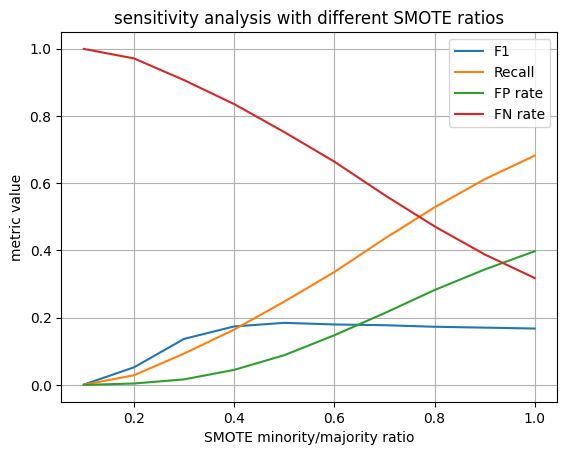

In [ ]:
sampling_strategies = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]  # minority-to-majority class ratio
f1_list, recall_list, fp_rate_list, fn_rate_list = [], [], [], []

for s in sampling_strategies:
    smote = SMOTE(sampling_strategy=s, random_state=42)
    X_res, y_res = smote.fit_resample(X_train_selected, y_train)
    clf = LogisticRegression(
        penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000, random_state=42
    )
    clf.fit(X_res, y_res)
    y_pred = clf.predict(X_val_selected)
    f1_list.append(f1_score(y_val, y_pred))
    recall_list.append(recall_score(y_val, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    fp_rate_list.append(fp_rate)
    fn_rate_list.append(fn_rate)

plt.plot(sampling_strategies, f1_list, label='F1')
plt.plot(sampling_strategies, recall_list, label='Recall')
plt.plot(sampling_strategies, fp_rate_list, label='FP rate')
plt.plot(sampling_strategies, fn_rate_list, label='FN rate')
plt.xlabel('SMOTE minority/majority ratio')
plt.ylabel('metric value')
plt.title('sensitivity analysis with different SMOTE ratios')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
f1_list

[0.001248179737882255,
 0.052377879834516264,
 0.13699889665318132,
 0.17408951536408357,
 0.18476958274321822,
 0.17997538874594474,
 0.1777512369902747,
 0.17313494099538224,
 0.1705106125488736,
 0.16785673923540834]

In [28]:
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_res, y_res = smote.fit_resample(X_train_selected, y_train)

In [29]:
X_res[num_cols] = scaler.inverse_transform(X_res[num_cols])
X_res["year_val"] = X_res["year_val"].map({False:2024,True:2025})

In [30]:
X_res["TotalSpaces"] = X_res["TotalSpaces"].round()

In [31]:
X_res

,laterHourFee,firstHourFee,day_off,district,half_hour_cos,lat,year_val,month_val_2,TotalSpaces,month_val_12,...,month_val_5,cloud_cover_mid,weekday_num_0,pressure_msl,vapour_pressure_deficit,month_val_11,wind_speed_10m,cloud_cover,precipitation,surface_pressure
0,0.0,0.0,True,False,9.659258e-01,22.994800,2024,False,3.0,False,...,False,0.0,False,1010.100000,0.900000,False,5.800000,15.000000,0.8,1009.500000
1,0.0,0.0,False,False,5.000000e-01,22.994800,2024,False,3.0,False,...,False,100.0,False,985.500000,0.210000,False,45.100000,100.000000,15.2,984.900000
2,20.0,20.0,False,False,-7.071068e-01,22.994800,2024,False,3.0,False,...,False,100.0,False,989.100000,0.700000,False,45.300000,100.000000,0.8,988.500000
3,0.0,0.0,False,False,3.826834e-01,22.994800,2024,False,3.0,False,...,False,90.0,False,1010.400000,0.950000,False,10.100000,99.000000,0.0,1009.800000
4,0.0,0.0,False,False,7.933533e-01,22.994800,2024,False,3.0,False,...,False,5.0,True,1006.800000,0.990000,False,7.100000,100.000000,0.0,1006.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998703,0.0,0.0,False,False,7.121175e-01,22.991830,2024,False,11.0,False,...,False,0.0,False,1012.420525,1.023667,True,5.402627,10.598249,0.0,1011.820525
2998704,0.0,0.0,True,False,8.660254e-01,22.991356,2024,False,5.0,False,...,False,14.0,False,1013.300000,1.200000,False,14.700000,100.000000,0.0,1012.700000
2998705,0.0,0.0,True,False,6.123234e-17,22.995890,2024,False,6.0,False,...,True,5.0,False,1012.300000,1.280000,False,6.300000,100.000000,0.0,1011.700000
2998706,20.0,20.0,False,False,-9.707776e-01,22.991190,2024,False,4.0,False,...,False,0.0,False,1007.047057,2.627530,False,20.352943,100.000000,0.0,1006.447057


In [32]:
X_res["is_full"] = y_res
X_res.to_csv('smote_data_raw.csv', index=False)

In [33]:
X_res

,laterHourFee,firstHourFee,day_off,district,half_hour_cos,lat,year_val,month_val_2,TotalSpaces,month_val_12,...,cloud_cover_mid,weekday_num_0,pressure_msl,vapour_pressure_deficit,month_val_11,wind_speed_10m,cloud_cover,precipitation,surface_pressure,is_full
0,0.0,0.0,True,False,9.659258e-01,22.994800,2024,False,3.0,False,...,0.0,False,1010.100000,0.900000,False,5.800000,15.000000,0.8,1009.500000,False
1,0.0,0.0,False,False,5.000000e-01,22.994800,2024,False,3.0,False,...,100.0,False,985.500000,0.210000,False,45.100000,100.000000,15.2,984.900000,False
2,20.0,20.0,False,False,-7.071068e-01,22.994800,2024,False,3.0,False,...,100.0,False,989.100000,0.700000,False,45.300000,100.000000,0.8,988.500000,False
3,0.0,0.0,False,False,3.826834e-01,22.994800,2024,False,3.0,False,...,90.0,False,1010.400000,0.950000,False,10.100000,99.000000,0.0,1009.800000,False
4,0.0,0.0,False,False,7.933533e-01,22.994800,2024,False,3.0,False,...,5.0,True,1006.800000,0.990000,False,7.100000,100.000000,0.0,1006.200000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998703,0.0,0.0,False,False,7.121175e-01,22.991830,2024,False,11.0,False,...,0.0,False,1012.420525,1.023667,True,5.402627,10.598249,0.0,1011.820525,True
2998704,0.0,0.0,True,False,8.660254e-01,22.991356,2024,False,5.0,False,...,14.0,False,1013.300000,1.200000,False,14.700000,100.000000,0.0,1012.700000,True
2998705,0.0,0.0,True,False,6.123234e-17,22.995890,2024,False,6.0,False,...,5.0,False,1012.300000,1.280000,False,6.300000,100.000000,0.0,1011.700000,True
2998706,20.0,20.0,False,False,-9.707776e-01,22.991190,2024,False,4.0,False,...,0.0,False,1007.047057,2.627530,False,20.352943,100.000000,0.0,1006.447057,True


: 